# Creating Word2Vec From Scratch
## A Toy Embedding Problem


In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re

C:\Users\booke\AppData\Local\Temp\ipykernel_20808\2631875547.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Read the CSV file
df = pd.read_csv("Shakespeare_data.csv")

# Convert the 'PlayerLine' column to a list of strings
lines_lst = df['PlayerLine'].to_list()

# Join the list elements into a single string, with space separating them
text = " ".join(str(x) for x in lines_lst)

# Reduce text for training
text = text[0 : len(text)]


Could you use one hot encoding to include POS tagging and positional data? 


In [3]:
text = text.lower()
# Extract tokens
tokens = re.split(r'\W+', text)

# Get rid of any empty strings
for i in range(len(tokens)):
    if tokens[i] == '':
        del tokens[i]

words = []
for token in tokens:
    if token not in words:
        words.append(token)
        
token_index = {}
for i, word in enumerate(words):
    token_index[word] = i
print(token_index, len(token_index))

{'act': 0, 'i': 1, 'scene': 2, 'london': 3, 'the': 4, 'palace': 5, 'enter': 6, 'king': 7, 'henry': 8, 'lord': 9, 'john': 10, 'of': 11, 'lancaster': 12, 'earl': 13, 'westmoreland': 14, 'sir': 15, 'walter': 16, 'blunt': 17, 'and': 18, 'others': 19, 'so': 20, 'shaken': 21, 'as': 22, 'we': 23, 'are': 24, 'wan': 25, 'with': 26, 'care': 27, 'find': 28, 'a': 29, 'time': 30, 'for': 31, 'frighted': 32, 'peace': 33, 'to': 34, 'pant': 35, 'breathe': 36, 'short': 37, 'winded': 38, 'accents': 39, 'new': 40, 'broils': 41, 'be': 42, 'commenced': 43, 'in': 44, 'strands': 45, 'afar': 46, 'remote': 47, 'no': 48, 'more': 49, 'thirsty': 50, 'entrance': 51, 'this': 52, 'soil': 53, 'shall': 54, 'daub': 55, 'her': 56, 'lips': 57, 'own': 58, 'children': 59, 's': 60, 'blood': 61, 'nor': 62, 'trenching': 63, 'war': 64, 'channel': 65, 'fields': 66, 'bruise': 67, 'flowerets': 68, 'armed': 69, 'hoofs': 70, 'hostile': 71, 'paces': 72, 'those': 73, 'opposed': 74, 'eyes': 75, 'which': 76, 'like': 77, 'meteors': 78, '

In [4]:
# Given a word, return the index in thee dictionary of words
def get_id(word):
    return token_index[word]

# Input: Id of a word
# Output: One-hot encoded word 
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

## Creating the Training Dataset
We are going to use a bag of words methods in which for a given word, we are going to grab to two words before and after. 

In [5]:
def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(get_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(get_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

# Define concat function for indices
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

## Building Our Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Skip-gram model
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear_out = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, input_word):
        embedded_word = self.embeddings(input_word)
        output = self.linear_out(embedded_word)
        return output


In [ ]:
# Define hyperparameters
vocab_size = len(token_index)  
embedding_dim = 50  
learning_rate = 0.01
epochs = 100
batch_size = 8  


# Initialize the model, loss function, and optimizer
model = SkipGramModel(vocab_size, embedding_dim)
loss_function = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(epochs):
    total_loss = 0

    # Fetch batches from the generator
    training_data_generator = generate_training_data_batch(tokens, token_index, window=2, batch_size=batch_size)
    
    for X_batch, y_batch in training_data_generator:
        # Convert to PyTorch tensors
        input_batch = torch.tensor(X_batch, dtype=torch.long)
        target_batch = torch.tensor(y_batch, dtype=torch.long)

        # Ensure the model's output is in floating-point format
        output = model(input_batch).float()

        # Compute the loss (CrossEntropyLoss expects raw logits in floating-point)
        loss = loss_function(output, target_batch)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update the parameters
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss:.4f}")


In [ ]:

word_embeddings = model.embeddings.weight.data
print(word_embeddings)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming `model` is your trained SkipGramModel and `token_index` contains the vocabulary

def visualize_embeddings(model, token_index, num_points=50):
    # Get the embeddings matrix from the model
    embeddings = model.embeddings.weight.data.cpu().numpy()  # Extract word embeddings from the model
    
    # Pick a subset of words to visualize (num_points)
    words = list(token_index.keys())[:num_points]
    word_embeddings = embeddings[:num_points]

    # Reduce the dimensionality of the embeddings using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(word_embeddings)

    # Plot the reduced embeddings with labels
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(words):
        x, y = reduced_embeddings[i, 0], reduced_embeddings[i, 1]
        plt.scatter(x, y)
        plt.annotate(label, (x, y), fontsize=12)

    plt.title('t-SNE Visualization of Word Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize the first 50 words' embeddings
visualize_embeddings(model, token_index, num_points=50)


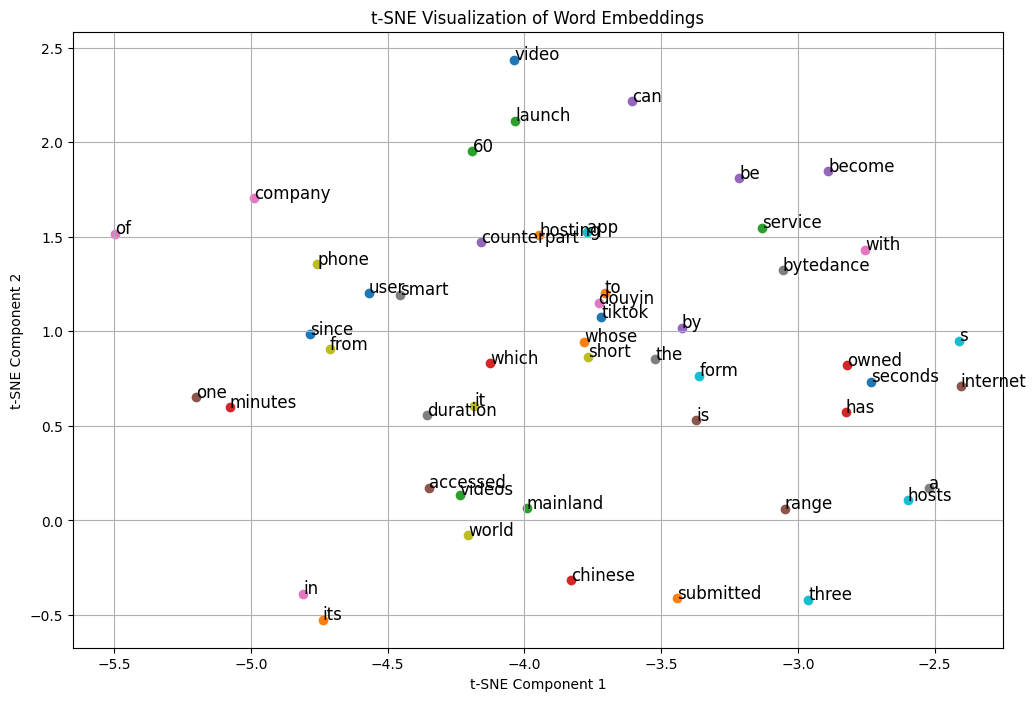

In [ ]:
min(5, 100, 23)